# Feature Engineering & Model's

## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Global Variables

In [2]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global Functions

In [3]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Import data

In [5]:
df = polars_read_excel(PATH_DATAFRAME)

Could not determine dtype for column 13, falling back to string
Could not determine dtype for column 14, falling back to string
Could not determine dtype for column 15, falling back to string


In [6]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

## Data Manipulation

In [7]:
df_engineered = (
    df # Start with the full DataFrame loaded from full_join.xlsx
    .filter(pl.col("PackagesHandled") > 0)
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"]))
    .with_columns([
        # Enhanced Date Features
        pl.col("DateOfReport").dt.ordinal_day().alias("report_day_of_year"),
        pl.col("DateOfReport").dt.week().alias("report_week_of_year"),
        pl.col("DateOfReport").dt.quarter().alias("report_quarter"),
        pl.when(pl.col("DateOfReport").dt.weekday().is_in([6, 7])) # Polars: Mon=1..Sun=7
            .then(1).otherwise(0).alias("is_weekend").cast(pl.Int8),

        (np.sin(2 * np.pi * pl.col("DateOfReport").dt.month() / 12)).alias('month_sin'),
        (np.cos(2 * np.pi * pl.col("DateOfReport").dt.month() / 12)).alias('month_cos'),
        (np.sin(2 * np.pi * (pl.col("DateOfReport").dt.weekday() - 1) / 7)).alias('weekday_sin'),
        (np.cos(2 * np.pi * (pl.col("DateOfReport").dt.weekday() - 1) / 7)).alias('weekday_cos'),

        # Your original calculated ratios
        (pl.col("TotalIncidents") / pl.col("PackagesHandled")).alias("TotalIncidents (%)"),
        (pl.col("AnomaliesDetected") / pl.col("PackagesHandled")).alias("AnomaliesDetected (%)"),


    ])
    .sort("DateOfReport")
)

# Define df_input by selecting ALL columns you want for your model's features + target
df_input = df_engineered.select([
    # --- New Date Features ---
    pl.col("DateOfReport").dt.day().alias("report_day_num"), # Keeping original day number
    "month_sin",
    "month_cos",
    "weekday_sin",
    "weekday_cos",
    "report_day_of_year",
    "report_week_of_year",
    "report_quarter",
    "is_weekend",

    # --- Original Categorical/Numerical Features from your initial select ---
    # (Excluding original simple Month, Day, Weekday if replaced by engineered versions)
    "SupplierName",
    "GarmentType",
    "Material",
    "Weight", 
    "ProposedUnitsPerCarton",
    "ProposedFoldingMethod",
    "ProposedLayout",
    "Size",
    "Collection",
    # "PreviousMonth", # Decide if/how to include this. If as string, add to categorical_features later.


    # --- Your Calculated Ratios ---
    "TotalIncidents (%)",
    "AnomaliesDetected (%)",

    # --- Scorecard Features ---
    "BadPackagingRate (%)",
    "OnTimeDeliveryRate (%)",
    "AverageCostPerIncident (€)",

    # --- Target Variable ---
    "PackagingQuality"
])


### Target Variable

In [8]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality"])
y = df_pd["PackagingQuality"]

In [9]:
### Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

### Split dataset

In [10]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## XGBoost

In [11]:
# Do this for both X_train and X_test
for col in categorical_features:
    if col in X_train.columns: # Check if column exists
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Define weights
weight_for_class_0 = 3.0
weight_for_class_1 = 1.0
sample_weights = np.where(y_train == 0, weight_for_class_0, weight_for_class_1)

# Instantiate the XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',  
    use_label_encoder=False,
    enable_categorical=True,
    tree_method='hist',
    n_estimators=1000, 
    learning_rate=0.05,
    random_state=42
)

# Train the model
model.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions on the test set
y_pred_xgb = model.predict(X_test) 
y_proba_xgb = model.predict_proba(X_test)[:, 1] 

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### Evaluation

In [12]:
# Summary report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40     26481
           1       0.86      0.75      0.80    107545

    accuracy                           0.70    134026
   macro avg       0.59      0.62      0.60    134026
weighted avg       0.75      0.70      0.72    134026



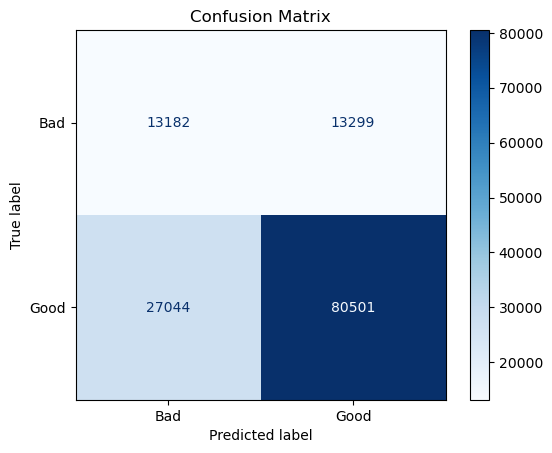

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6897


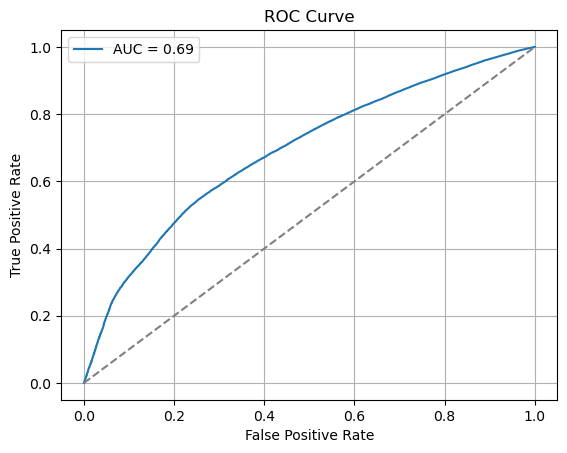

In [14]:
# Get predicted probabilities for the positive class ("Good" = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
9,SupplierName,0.315038
20,BadPackagingRate (%),0.157365
11,Material,0.077221
18,TotalIncidents (%),0.054840
12,Weight,0.027596
10,GarmentType,0.025925
21,OnTimeDeliveryRate (%),0.023375
7,report_quarter,0.023105
16,Size,0.022794
2,month_cos,0.022287


## LightGBM

In [16]:
#weights
weight_for_class_0 = 3.0
weight_for_class_1 = 1.0
sample_weights = np.where(y_train == 0, weight_for_class_0, weight_for_class_1)

# Instantiate the LightGBM classifier
model_lgb = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

actual_categorical_in_train = [col for col in categorical_features if col in X_train.columns and X_train[col].dtype.name == 'category']

# Train the model
model_lgb.fit(X_train, y_train, sample_weight=sample_weights,categorical_feature=actual_categorical_in_train)
# Make predictions on the test set
y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 250935, number of negative: 61790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1359
[LightGBM] [Info] Number of data points in the train set: 312725, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.575137 -> initscore=0.302840
[LightGBM] [Info] Start training from score 0.302840


### Evaluation

In [17]:
# Summary report
y_pred = model_lgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.51      0.40     26481
           1       0.86      0.75      0.80    107545

    accuracy                           0.70    134026
   macro avg       0.59      0.63      0.60    134026
weighted avg       0.76      0.70      0.72    134026



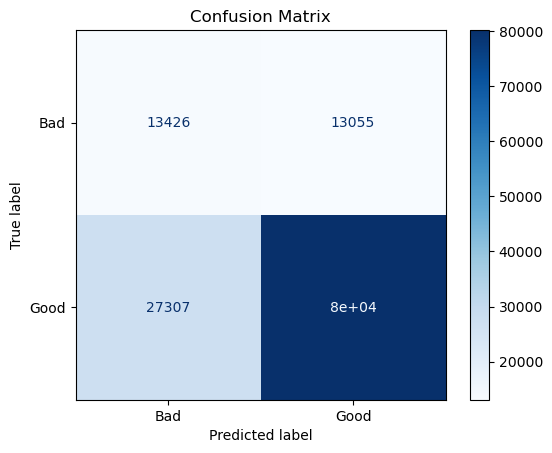

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6951


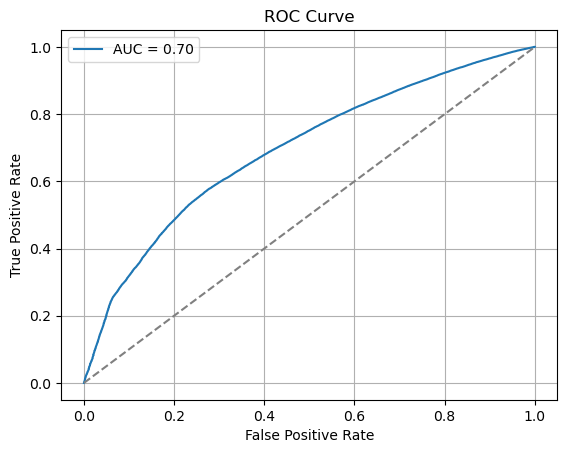

In [19]:
# Get predicted probabilities for the positive class ("Good" = 1)
y_proba = model_lgb.predict_proba(X_test)[:, 1]

# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model_lgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
12,Weight,4444
13,ProposedUnitsPerCarton,3426
0,report_day_num,3030
5,report_day_of_year,3024
22,AverageCostPerIncident (€),1652
18,TotalIncidents (%),1441
3,weekday_sin,1433
10,GarmentType,1353
20,BadPackagingRate (%),1351
21,OnTimeDeliveryRate (%),1297


## Export the model

In [21]:
# Create a complete, properly aligned results DataFrame
# First, convert y_test to a Series if it isn't already
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')
y_proba_series = pd.Series(y_proba, name='Probability')

# Make sure X_test is a DataFrame
X_test_df = pd.DataFrame(X_test) if not isinstance(X_test, pd.DataFrame) else X_test.copy()

# Reset all indices to ensure proper alignment
X_test_df = X_test_df.reset_index(drop=True)
y_test_series = y_test_series.reset_index(drop=True)
y_pred_series = y_pred_series.reset_index(drop=True)
y_proba_series = y_proba_series.reset_index(drop=True)

# Create the results DataFrame step by step to ensure proper column tracking
results_df = X_test_df.copy()  # Start with features
results_df['Actual'] = y_test_series  # Add actual values
results_df['Predicted'] = y_pred_series  # Add predictions
results_df['Probability'] = y_proba_series  # Add probabilities
results_df['Correct'] = (results_df['Actual'] == results_df['Predicted'])  # Add correctness indicator


# Export to Excel - use engine='openpyxl' for better handling of large datasets
results_df.to_excel("lightgbm_results.xlsx", index=False, engine='openpyxl')

